# Deep Layout Parsing

In this tutorial, we will show how to use the `layoutparser` API to 

1. Load Deep Learning Layout Detection models and predict the layout of the paper image
2. Use the coordinate system to parse the output 

The `paper-image` is from https://arxiv.org/abs/2004.08686.

In [1]:
import layoutparser as lp
import cv2
print(lp.__version__)


0.3.4


## Use Layout Models to detect complex layout 

`layoutparser` can identify the layout of the given document with only 4 lines of code.

In [2]:
image_path = "./data/paper-image.jpg"
image = cv2.imread(image_path)
if image is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully.")

image = image[..., ::-1] 
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

Image loaded successfully.


In [3]:
  
# model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                  label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
model = lp.models.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table",4:"Figure"})
    # Load the deep layout model from the layoutparser API 
    # For all the supported model, please check the Model 
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

In [4]:
import os

# Model configuration and label map
config_path = 'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config'
label_map = {0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"}
extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8]

# Initialize the model, which will download the files
model = lp.Detectron2LayoutModel(config_path, extra_config=extra_config, label_map=label_map)

# Define paths to the downloaded files
weights_file_with_query = os.path.expanduser('~/.torch/iopath_cache/s/dgy9c10wykk4lq4/model_final.pth?dl=1')
lock_file_with_query = os.path.expanduser('~/.torch/iopath_cache/s/dgy9c10wykk4lq4/model_final.pth?dl=1.lock')

# Define paths for renaming
weights_file = os.path.expanduser('~/.torch/iopath_cache/s/dgy9c10wykk4lq4/model_final.pth')
lock_file = os.path.expanduser('~/.torch/iopath_cache/s/dgy9c10wykk4lq4/model_final.pth.lock')

# Rename the files if they exist
if os.path.exists(weights_file_with_query):
    os.rename(weights_file_with_query, weights_file)

if os.path.exists(lock_file_with_query):
    os.rename(lock_file_with_query, lock_file)

# Now reinitialize the model to use the renamed files
model = lp.Detectron2LayoutModel(config_path, extra_config=extra_config, label_map=label_map)


In [5]:
layout = model.detect(image)
    # Detect the layout of the input image

/home/kotda/.local/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


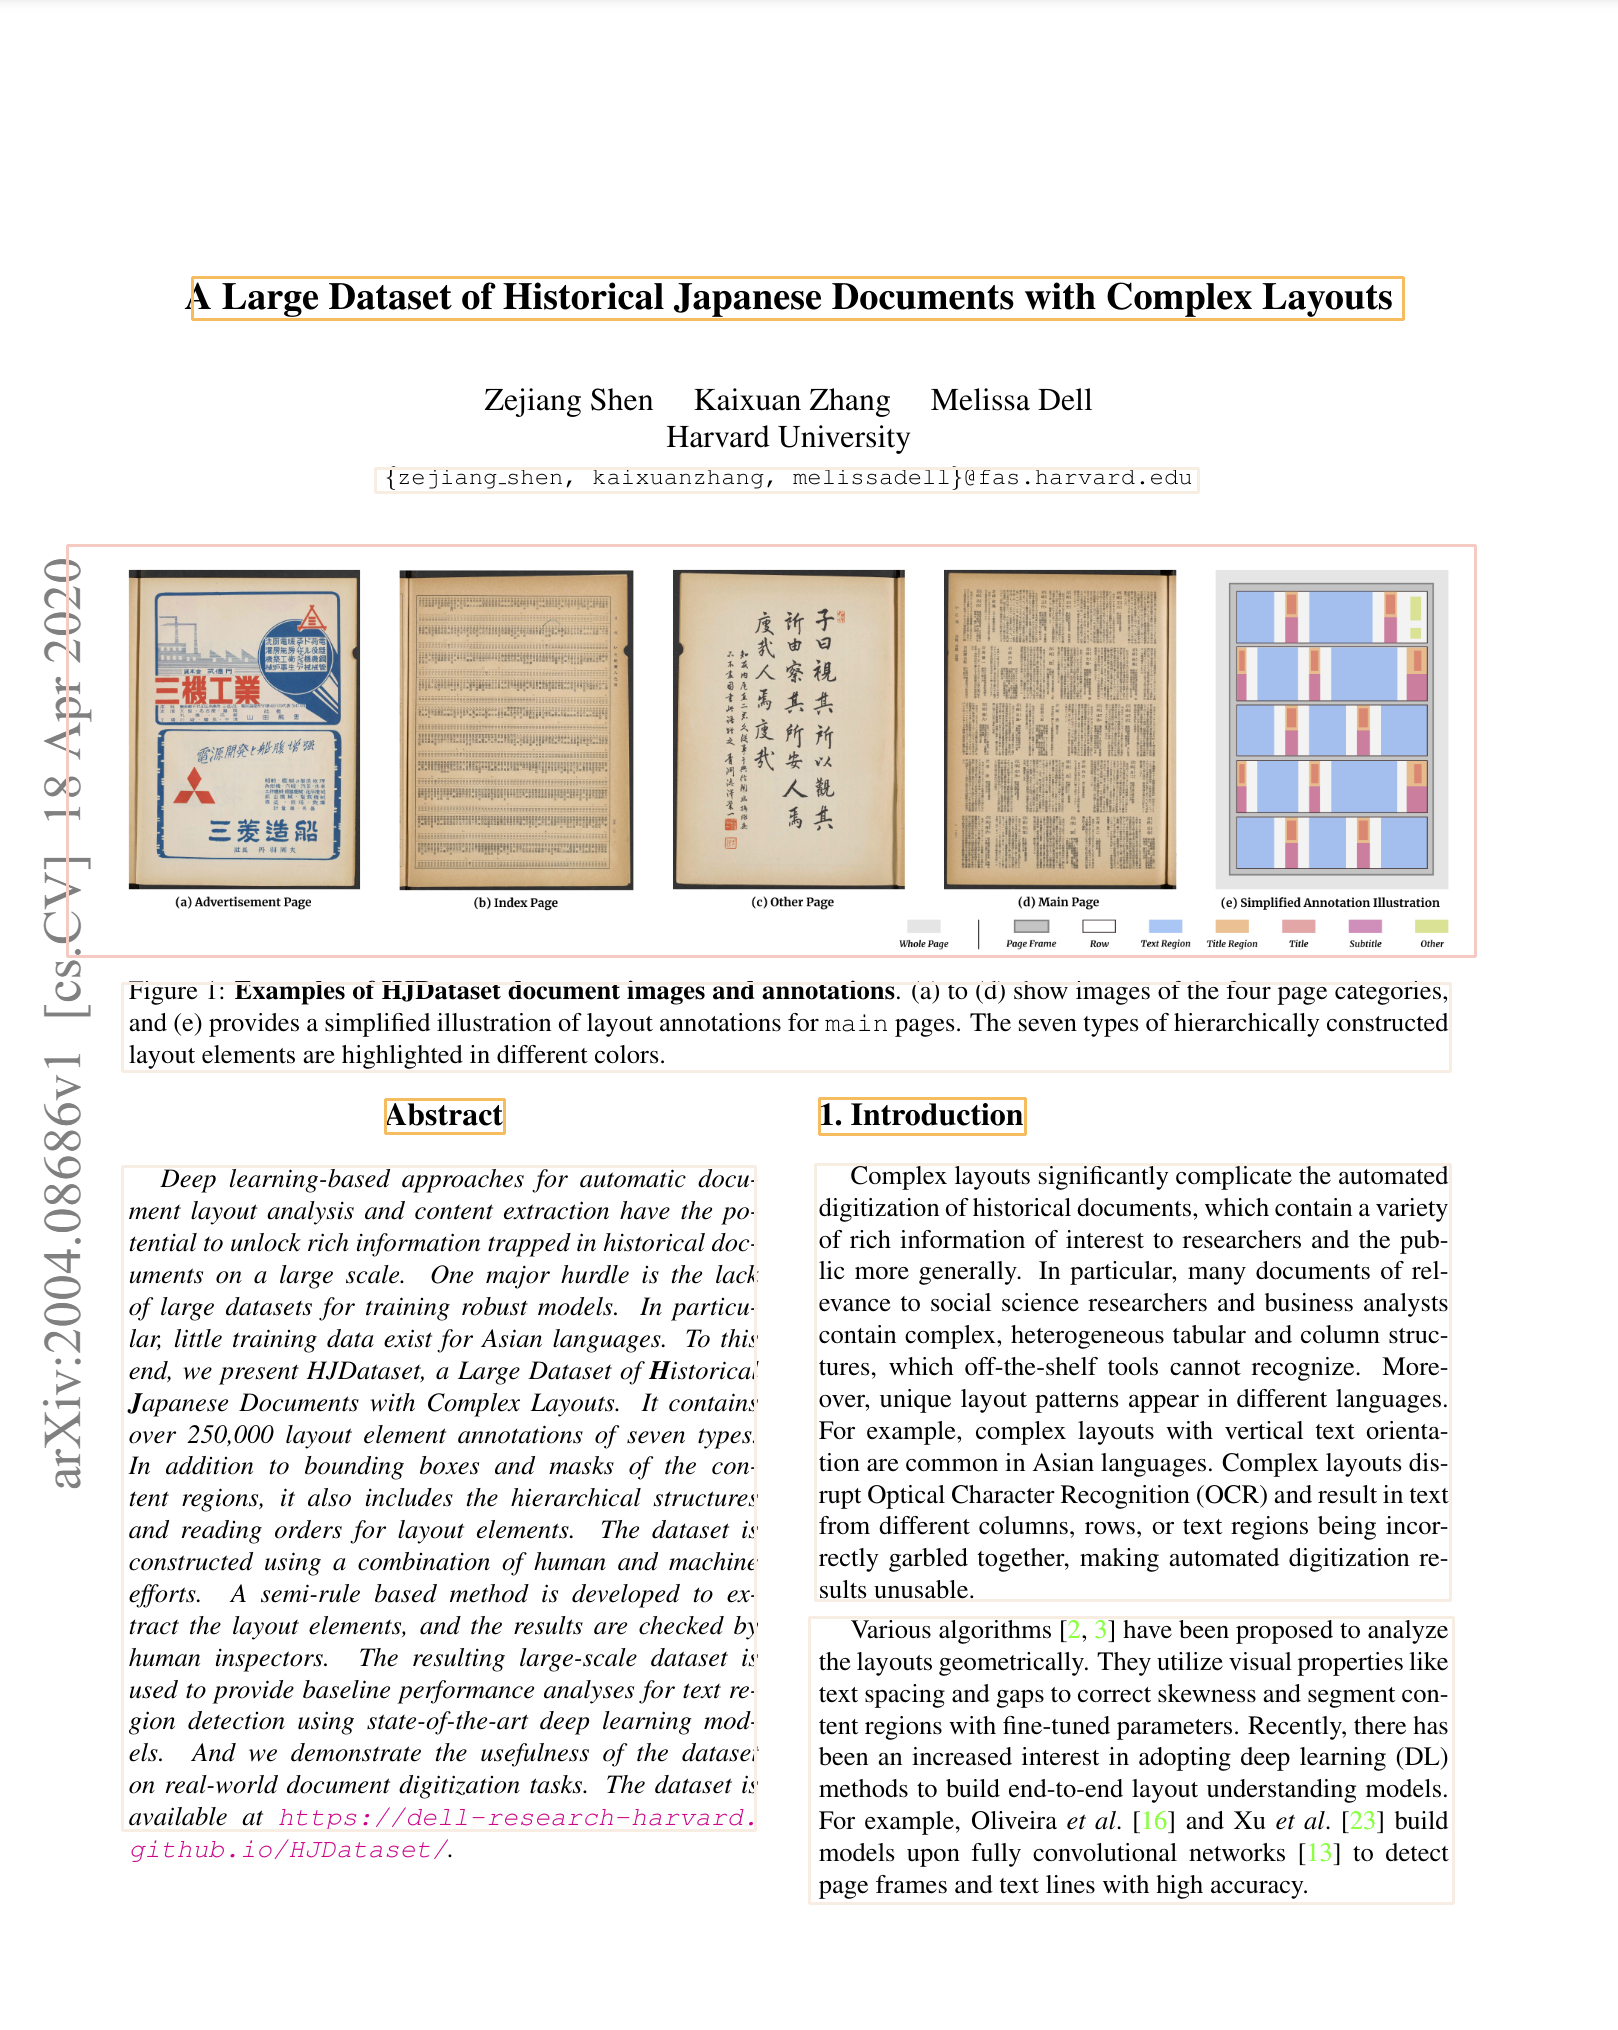

In [6]:
lp.draw_box(image, layout, box_width=3)
    # Show the detected layout of the input image

## Check the results from the model 

In [7]:
type(layout)         

layoutparser.elements.layout.Layout

The `layout` variable is a `Layout` instance, which is inherited from list and supports handy methods for layout processing.

In [8]:
layout[0]

TextBlock(block=Rectangle(x_1=67.57340240478516, y_1=545.5858154296875, x_2=1475.2471923828125, y_2=956.7763671875), text=None, id=None, type=Figure, parent=None, next=None, score=0.9984257221221924)

`layout` contains a series of `TextBlock`s. They store the coordinates in the `.block` variable and other information of the blocks like block type in `.type`, text in `.text`, etc. More information can be found at the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/elements.html#layoutparser.elements.TextBlock). 

## Use the coordinate system to process the detected layout

Firstly we filter text regions of specific type:

In [9]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As you will see below, the text recognized as section 5.2 will be dropped
from our layout-recognized text regions as it is parsed as a TextBlock of
type 'Title' as indicated by its different colored bounding box in the image
above.

As there could be text regions detected inside the figure region, we just drop them:

In [10]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally, sort the text regions and assign ids:

In [11]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

Visualize the cleaned text blocks:

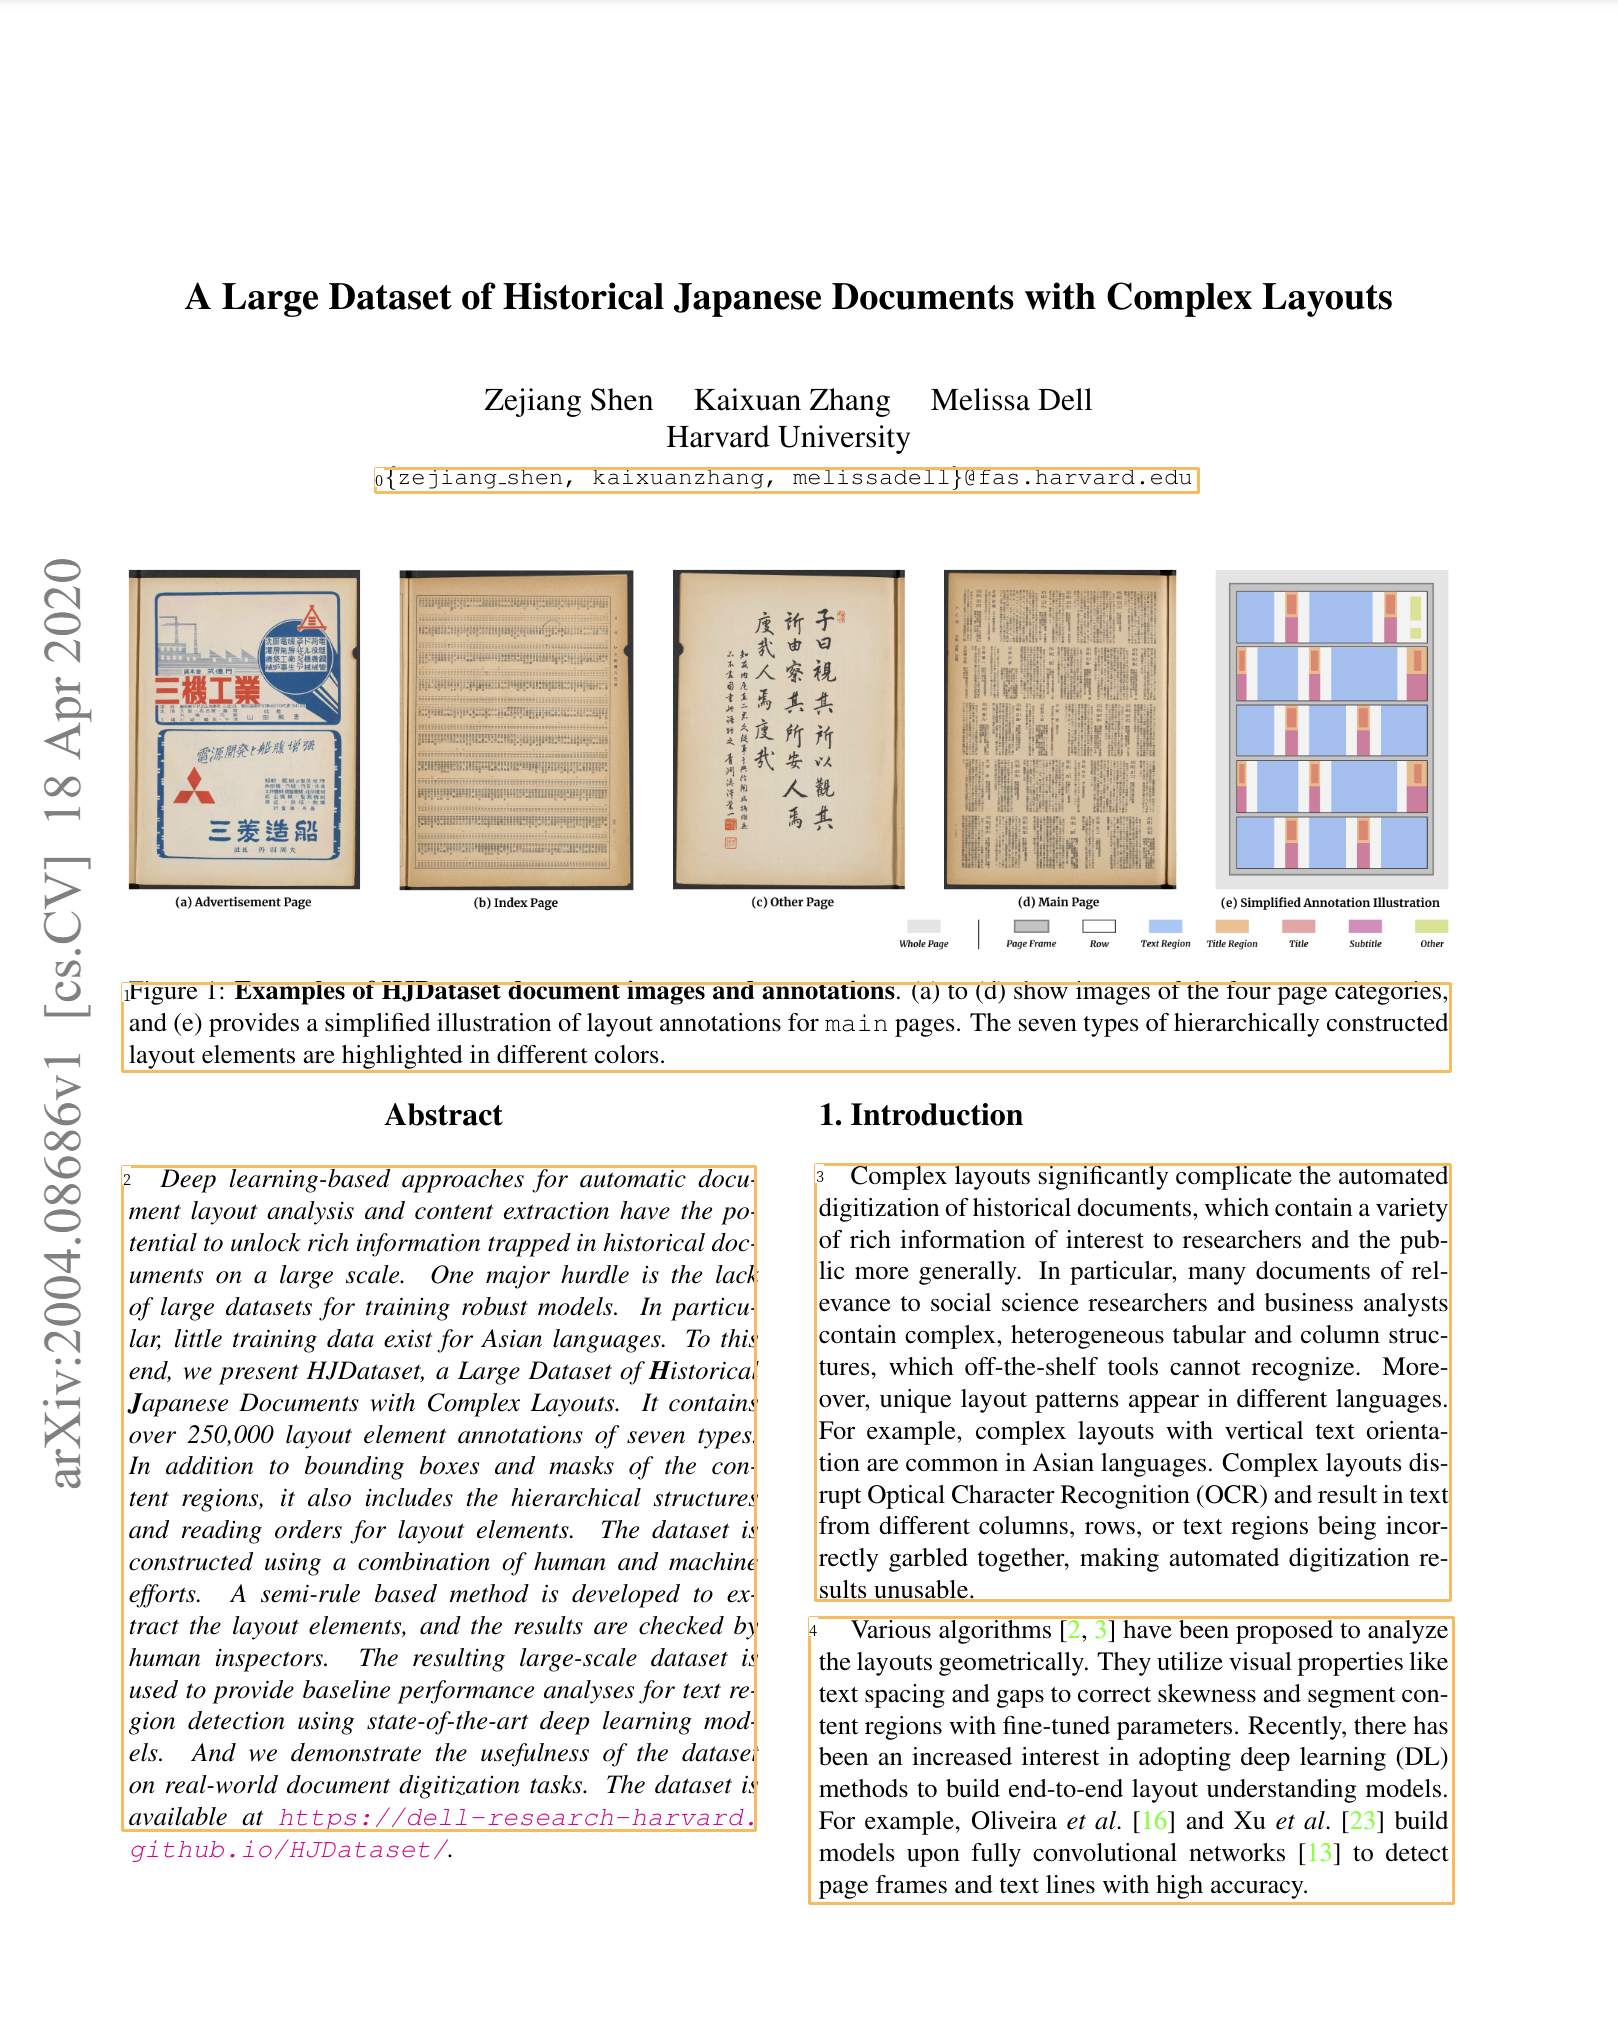

In [12]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

## Fetch the text inside each text region

We can also combine with the OCR functionality in `layoutparser` to fetch the text in the document. 

In [13]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [14]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [15]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

{zejiang_-shen, kaixuanzhang, melissadell}@fas.harvard.edu

---
Figure 1: Examples of HJDataset document images and annotations. (a) to (d) show images of the four page categories,
and (e) provides a simplified illustration of layout annotations for main pages. The seven types of hierarchically constructed
layout elements are highlighted in different colors.

---
Deep learning-based approaches for automatic docu-
ment layout analysis and content extraction have the po-
tential to unlock rich information trapped in historical doc-
uments on a large scale. One major hurdle is the lack
of large datasets for training robust models. In particu-
lar, little training data exist for Asian languages. To this
end, we present HJDataset, a Large Dataset of Historical
Japanese Documents with Complex Layouts. It contains
over 250,000 layout element annotations of seven types.
In addition to bounding boxes and masks of the con-
tent regions, it also includes the hierarchical structures
and reading 